<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [56]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data.csv'
column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff', 'Total Area', 'Kurtosis', 'Power', '99% Bandwidth', 'Top Bandwidth Frequency', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 14)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto
raw_dataset.tail() # muestra las últimas 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [46]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [57]:
# Extracción de subconjuntos: bloque de código original original
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [32]:
#del train_dataset['Power']
#del test_dataset['Power']
#del train_dataset['Total Area']
#del test_dataset['Total Area']
a= train_dataset.pop('Power')
b=train_dataset.pop('Total Area')
c=test_dataset.pop('Power')
d=test_dataset.pop('Total Area')
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 11)
Formato del dataset de test: (895, 11)


In [58]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3577.0,1.363736,2.541487,2.837595e-04,0.237643,0.414133,1.002667,16.584792
Median,3577.0,1.369368,2.557869,1.507318e-16,0.236495,0.415317,0.992196,17.078574
Standard Dev,3577.0,0.139336,0.348625,4.128630e-04,0.005854,0.028489,0.112110,5.361308
Max Value,3577.0,1.609104,2.811326,3.862719e-03,0.289459,0.483214,1.309665,19.922996
Min Value,3577.0,1.088882,2.325957,-2.571784e-01,0.101178,0.292940,0.643248,16.049411
Standard Dev 1st diff,3577.0,0.022398,0.043155,2.152890e-04,0.001013,0.005274,0.022573,0.798314
Median 1st diff,3577.0,-0.000683,0.003753,-1.354304e-01,-0.000497,-0.000051,0.000060,0.036675
Standard Dev 2nd diff,3577.0,0.010558,0.019329,1.297775e-04,0.000577,0.002690,0.011364,0.380591
Total Area,3577.0,162.289565,302.475479,3.286816e-02,28.273530,49.281242,119.288862,1981.662176
Kurtosis,3577.0,4.951246,5.347919,1.026555e+00,2.113631,2.955994,5.604172,113.812119


### 3.2. Normalización y estandarización de todos los datos

In [59]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3577, 13)
Formato del dataset de test: (894, 13)


In [60]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3577.0,-5.462657e-17,1.0,-0.536478,-0.443084,-0.373641,-0.142070,5.989035
Median,3577.0,-6.257226e-17,1.0,-0.535355,-0.442897,-0.372987,-0.147456,6.141520
Standard Dev,3577.0,4.072163e-17,1.0,-0.398489,-0.382881,-0.317954,-0.078095,14.978786
Max Value,3577.0,-3.823860e-17,1.0,-0.570991,-0.469403,-0.400483,-0.106512,6.514325
Min Value,3577.0,-1.489816e-17,1.0,-0.578713,-0.424644,-0.342200,-0.191592,6.431989
Standard Dev 1st diff,3577.0,-1.688458e-17,1.0,-0.514032,-0.495538,-0.396813,0.004037,17.979705
Median 1st diff,3577.0,1.390495e-17,1.0,-35.899645,0.049563,0.168281,0.197925,9.952909
Standard Dev 2nd diff,3577.0,7.250436e-17,1.0,-0.539486,-0.516336,-0.407024,0.041722,19.143874
Total Area,3577.0,1.037905e-16,1.0,-0.536429,-0.443064,-0.373612,-0.142163,6.014942
Kurtosis,3577.0,2.979631e-18,1.0,-0.733873,-0.530602,-0.373089,0.122090,20.355744


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [61]:
from keras import Sequential, layers, activations

def build_model_best(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

def build_model_ELU(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 4, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_best(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 13, 27)              │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 13, 27)              │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 13, 22)              │           1,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 13, 22)              │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 13, 22)              │           1,474 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 13, 22)              │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 286)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 22)                  │           6,314 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,980 (38.98 KB)

 Trainable params: 9,838 (38.43 KB)

 Non-trainable params: 142 (568.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [62]:
EPOCHS = 700
history = model.fit(normed_train_data, train_labels, batch_size=511,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)
#1min 48s

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
695,0.773506,0.762503,0.433995,0.788193,0.864282,0.625698,0.748252,0.762068,0.666667,0.747664,695
696,0.771059,0.762503,0.438484,0.779575,0.875639,0.642458,0.748252,0.775350,0.672691,0.782710,696
697,0.777700,0.762503,0.442349,0.799043,0.853492,0.624302,0.748252,0.766300,0.680272,0.700935,697
698,0.768263,0.762503,0.446383,0.790784,0.847814,0.634078,0.748252,0.799315,0.654275,0.822430,698
699,0.776302,0.762503,0.444711,0.780952,0.884725,0.634078,0.748252,0.781071,0.693023,0.696262,699


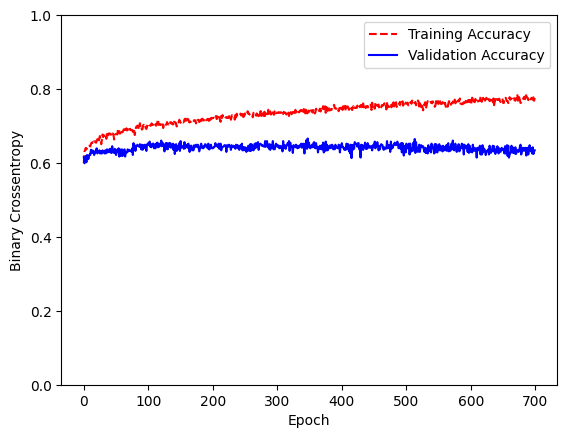

In [64]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [65]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step - binary_accuracy: 0.6711 - f1_score: 0.7618 - loss: 0.7469 - precision: 0.7336 - recall: 0.7309
Test accuracy: 67.11%
Test loss: 0.747


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


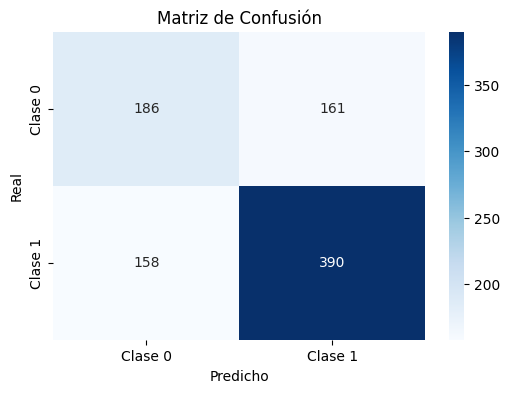

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.54      0.54      0.54       347
     Clase 1       0.71      0.71      0.71       548

    accuracy                           0.64       895
   macro avg       0.62      0.62      0.62       895
weighted avg       0.64      0.64      0.64       895



In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
